In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import Experiment, RestartingExperiment

In [3]:
data = pd.read_csv("../../../sonar.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:
X = data.loc[:, data.columns[:-1]].values
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
y = data.loc[:, data.columns[-1]]
y = np.where(y == "R", 1, -1)

X = torch.tensor(X)
y = torch.tensor(y)

X.shape, y.shape

(torch.Size([208, 61]), torch.Size([208]))

In [5]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
model = LogisticRegressionGD(X_train, y_train, 1e-2)

In [7]:
model.fit(1e-4, max_iter=1000000)

In [8]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.8095, dtype=torch.float64)

In [9]:
len(model.log)

25345

## Without restarting

In [10]:
experiment = Experiment(model.log, model.obj, values=model.value_log)

In [11]:
experiment.run_method("VLT", h_algorithm, 5, method_kwargs={"k": 4, "type": "t"})

In [12]:
experiment.run_method("VLU", h_algorithm, 5, method_kwargs={"k": 4, "type": "u"})

In [13]:
experiment.run_method("VLV", h_algorithm, 6, method_kwargs={"k": 4, "type": "v"})

In [14]:
experiment.run_method("RRE+QR", RRE, 4, method_kwargs={"qr": True})

In [15]:
experiment.run_method("MMPE", MMPE, 4)

In [16]:
experiment.run_method("Epsilon inv", vector_epsilon_v1, 8, method_kwargs={"k": 4})

In [17]:
k = 4
n = 5
p = 7
m = np.arange(n)[None, :] + 1 + (p - 1) * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [18]:
experiment.run_method("VJT", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "t"})

In [19]:
experiment.run_method("VJU", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "u"})

In [20]:
k = 4
n = 6
p = 7
m = np.arange(n)[None, :] + 1 + (p - 1) * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [21]:
experiment.run_method("VJV", j_algorithm, 6, method_kwargs={"deltas": deltas, "type": "v"})

In [22]:
k = 4
n = 5
m = np.arange(n)[None, :] + 1 + 2 * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [23]:
experiment.run_method("VST", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "t"})

In [24]:
experiment.run_method("VSU", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "u"})

In [25]:
k = 4
n = 6
p = 3
m = np.arange(n)[None, :] + 1 + 2 * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [26]:
experiment.run_method("VSV", j_algorithm, 6, method_kwargs={"deltas": deltas, "type": "v"})

In [43]:
l = 2
k = 2 * l
n = 5
alpha = 0.5
delta_l = np.ones((l, n)) + np.arange(l)[:, None]
deltas = np.zeros((k, n), dtype=np.complex)
deltas[::2] = np.exp(2j * alpha * np.arange(n)[None, :])
deltas[1::2] = np.exp(-2j * alpha * np.arange(n)[None, :]) * delta_l
deltas = np.real(deltas)

In [44]:
experiment.run_method("VIT", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "t"})

In [45]:
experiment.run_method("VIU", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "u"})

In [46]:
l = 2
k = 2 * l
n = 6
alpha = 0.5
delta_l = np.ones((l, n)) + np.arange(l)[:, None]
deltas = np.zeros((k, n), dtype=np.complex)
deltas[::2] = np.exp(2j * alpha * np.arange(n)[None, :])
deltas[1::2] = np.exp(-2j * alpha * np.arange(n)[None, :]) * delta_l
deltas = np.real(deltas)

In [47]:
experiment.run_method("VIV", j_algorithm, 6, method_kwargs={"deltas": deltas, "type": "v"})

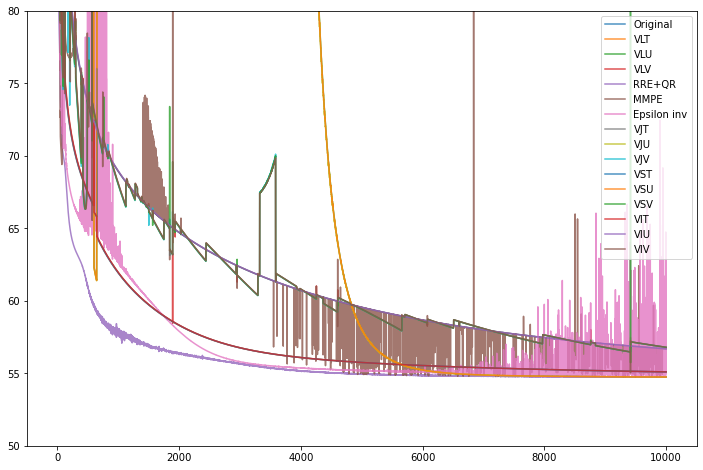

In [48]:
experiment.plot_values(n=10000, ylim=(50, 80), figsize=(12, 8))

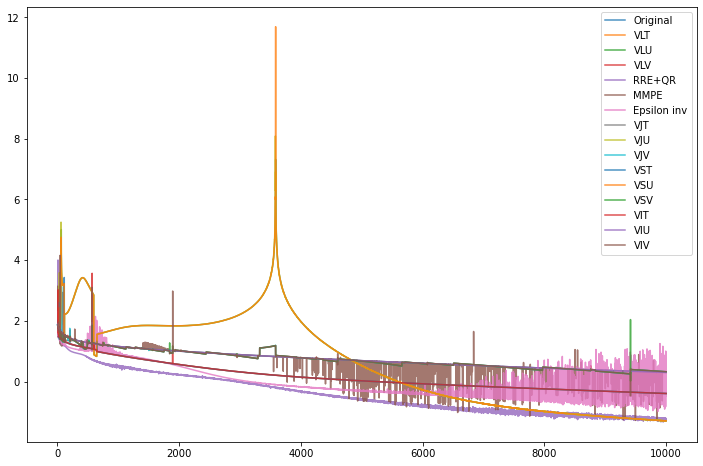

In [49]:
experiment.plot_log_diff(n=10000, figsize=(12, 8))

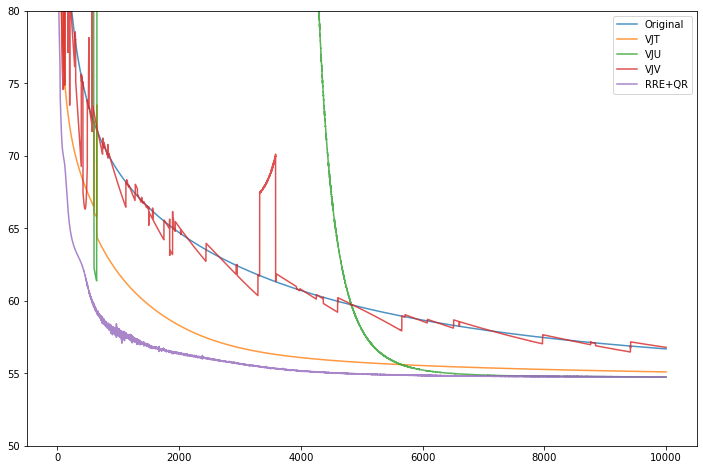

In [50]:
experiment.plot_values(n=10000, figsize=(12, 8), ylim=(50, 80),
                      methods=["VJT", "VJU", "VJV", "RRE+QR"])

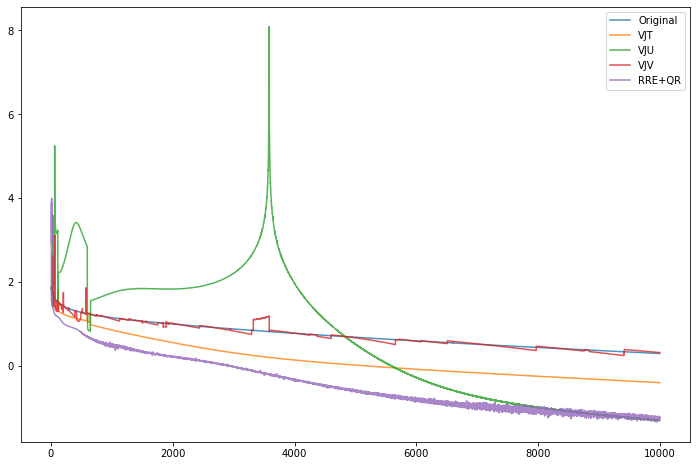

In [51]:
experiment.plot_log_diff(n=10000, figsize=(12, 8),
                      methods=["VJT", "VJU", "VJV", "RRE+QR"])

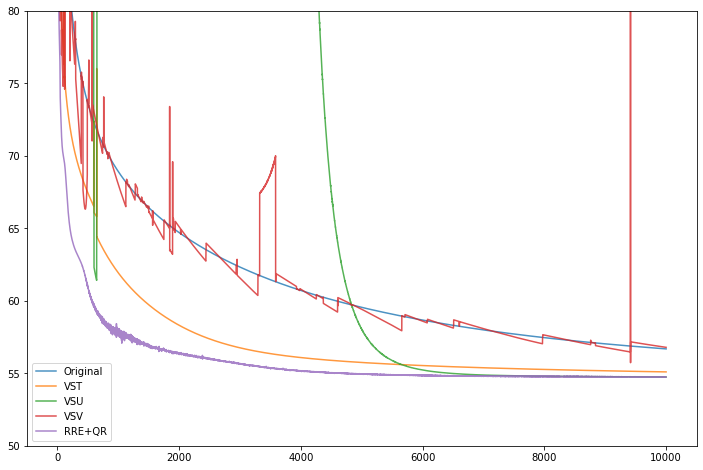

In [52]:
experiment.plot_values(n=10000, figsize=(12, 8), ylim=(50, 80),
                      methods=["VST", "VSU", "VSV", "RRE+QR"])

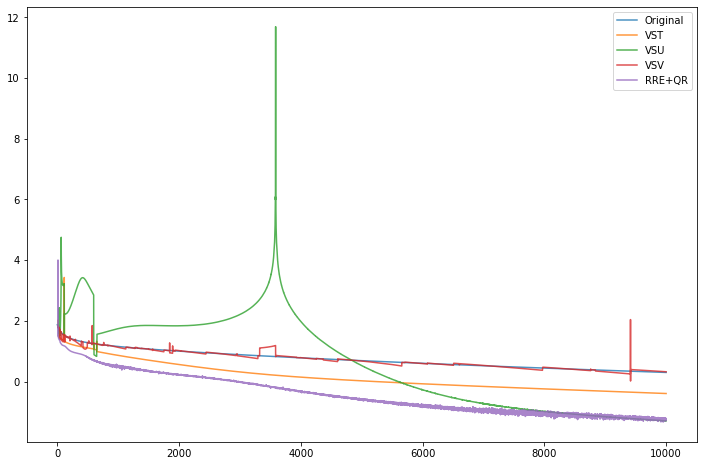

In [53]:
experiment.plot_log_diff(n=10000, figsize=(12, 8),
                      methods=["VST", "VSU", "VSV", "RRE+QR"])

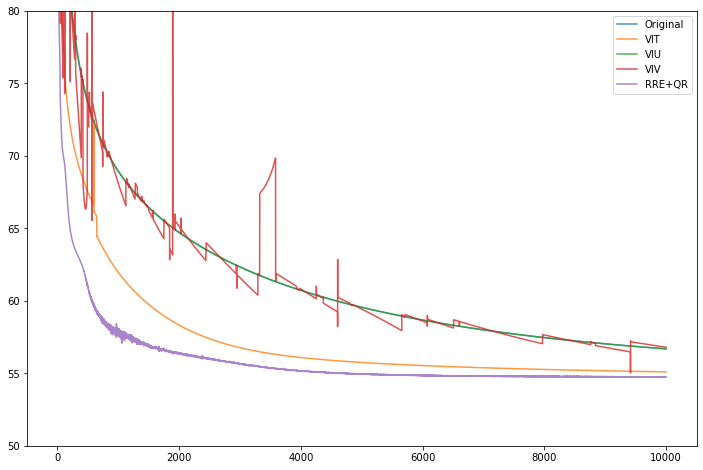

In [54]:
experiment.plot_values(n=10000, figsize=(12, 8), ylim=(50, 80),
                      methods=["VIT", "VIU", "VIV", "RRE+QR"])

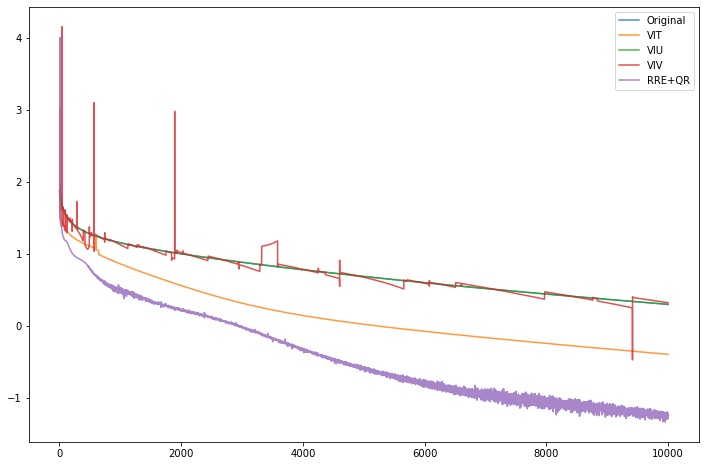

In [55]:
experiment.plot_log_diff(n=10000, figsize=(12, 8),
                      methods=["VIT", "VIU", "VIV", "RRE+QR"])

In [56]:
model.theta = experiment.best_x
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.8095, dtype=torch.float64)